In [1]:
import torch
import pandas as pd
import numpy as np

from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

In [2]:
!poetry run poe download-class-datasets

Poe => mkdir -p examples/regression/datasets
Poe => curl -L -o examples/classification/datasets/iris_training.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_training.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0   8098      0 --:--:-- --:--:-- --:--:--  8124
Poe => curl -L -o examples/classification/datasets/iris_test.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_test.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598  100   598    0     0   2065      0 --:--:-- --:--:-- --:--:--  2062


In [3]:
def compute_accuracy(loader, model, num_classes):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for data, labels in loader:
        predictions = model(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        predictions = torch.tensor([ [float(p)] for p in predictions  ]).numpy()
        labels = labels.numpy() 
        
        for i in range(num_classes):
            class_mask = (labels == i)
            class_correct[i] += np.sum(predictions[class_mask] == labels[class_mask])
            class_total[i] += np.sum(class_mask)

    class_accuracy = class_correct / class_total

    # Print accuracy for each class
    for i in range(num_classes):
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')

    # Compute and print general accuracy
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f'Overall accuracy: {overall_accuracy:.2f}')

In [4]:
kb = KnowledgeBase("multi_config.yaml")

In [5]:
compute_accuracy(kb.loaders[0], model = kb.predicates["Iris"], num_classes=3)

Accuracy for class 0: 0.00
Accuracy for class 1: 0.00
Accuracy for class 2: 1.00
Overall accuracy: 0.35


In [6]:
kb.optimize(num_epochs=801, log_steps=200)

['∀ flower.(((species == setosa) -> (Iris(flower, output) & output[0])))', '∀ flower.(((species == versicolor) -> (Iris(flower, output) & output[1])))', '∀ flower.(((species == virginica) -> (Iris(flower, output) & output[2])))']
Rule Outputs:  [tensor(0.5457, grad_fn=<RsubBackward1>), tensor(0.4643, grad_fn=<RsubBackward1>), tensor(0.5697, grad_fn=<RsubBackward1>)]
Epoch 1/801, Loss: 0.4755798578262329

['∀ flower.(((species == setosa) -> (Iris(flower, output) & output[0])))', '∀ flower.(((species == versicolor) -> (Iris(flower, output) & output[1])))', '∀ flower.(((species == virginica) -> (Iris(flower, output) & output[2])))']
Rule Outputs:  [tensor(0.7613, grad_fn=<RsubBackward1>), tensor(0.6516, grad_fn=<RsubBackward1>), tensor(0.7617, grad_fn=<RsubBackward1>)]
Epoch 201/801, Loss: 0.2799828052520752

['∀ flower.(((species == setosa) -> (Iris(flower, output) & output[0])))', '∀ flower.(((species == versicolor) -> (Iris(flower, output) & output[1])))', '∀ flower.(((species == virgi

In [7]:
compute_accuracy(kb.loaders[0], model = kb.predicates["Iris"], num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.83
Accuracy for class 2: 1.00
Overall accuracy: 0.95


## Computation Graph 

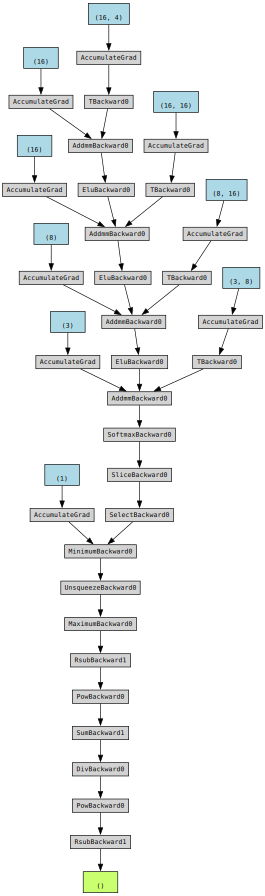

In [8]:
batch = next(iter(kb.loaders[0]))

var_mapping = {}

kb.partition_data(var_mapping,batch, kb.loaders[0] )

kb.rules[0].comp_graph(var_mapping)